### Movie DataBase 
    The goal of this project was to create a program that generates a database solely based on movie titles, and scrapes all the necessary information about each movie.

#### Importing the necessary packages

In [179]:
import numpy as np
import pandas as pd
import sqlite3
import names
import re
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

##### Here we create an empt database that we will later on fill up with data

In [165]:
conn = sqlite3.connect('movie_database.db')

c = conn.cursor()

c.execute("CREATE TABLE reviews(review_id INTEGER PRIMARY KEY AUTOINCREMENT,\
          first_name text NOT NULL, \
          last_name text NOT NULL, \
          movie_title text NOT NULL, \
          rating int NOT NULL)")

c.execute("CREATE TABLE movies(movie_title text NOT NULL UNIQUE,\
            genre text NOT NULL, \
            year_of_production int NOT NULL)")

c.execute("CREATE TABLE box_office(movie_title text NOT NULL UNIQUE, \
            box_office int NOT NULL, \
            budget int NOT NULL)")

c.execute("CREATE TABLE directors(movie_title text NOT NULL UNIQUE, \
            director text NOT NULL)")


conn.commit()
conn.close()

#  <font color='red'>EMERGENCY FUNCTION</font>

In [163]:
def clear_database():
    conn = sqlite3.connect('movie_database.db')
    c = conn.cursor()

    c.execute("DROP table reviews")
    c.execute("DROP table  movies")
    c.execute("DROP table box_office")
    c.execute("DROP table directors")
    c.execute("DROP table ratings")
    
    conn.commit()
    conn.close()

# Scraping movie data

#### box office scraping function
- we used the-numbers.com site to scrape data about movie budgets. This website had pretty accurate and specific numbers. We only had to make a special case if a movie title contained prefix 'The', and put it at the end of the title

In [6]:
def box_office_scraper(movie_title):
    if movie_title[:3] == 'the':
        title_strings = movie_title.split()
        the = title_strings[0]
        final_string = '-'.join(title_strings[1:]) + '-the'
        URL = 'https://www.the-numbers.com/movie/' + final_string +'#tab=summary'  
    else:
        title_strings = movie_title.split()
        final_string = '-'.join(title_strings) 
        URL = 'https://www.the-numbers.com/movie/' + final_string + '#tab=summary' 
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    results = soup.find(id='movie_finances')
    box_office = results.find_all(class_ = 'data')[2].text[1:].replace(',','')
    return int(box_office)

#### genre scraping function
- for genre we used yet another website, rotten tomatoes. This time the website was less ocnsistent with the addresses for the films, sometimes 'the' was there and sometimes it wasn't, so to two special cases were required. For the genre, we care about the most representative, and we select the first one from the list

In [7]:
def genre_scraper(movie_title):
    if movie_title[:3] == 'the':
        try:
            string = movie_title.split()
            string = '_'.join(string)
            URL = 'https://www.rottentomatoes.com/m/' + string
            page = requests.get(URL)
            soup = BeautifulSoup(page.content, 'html.parser')
            results = soup.find(class_ = 'meta-value genre')
            genre = results.text.split()[0][:-1]
        except AttributeError:
            try:
                string = movie_title[4:].split()
                string = '_'.join(string)
                URL = 'https://www.rottentomatoes.com/m/' + string
                page = requests.get(URL)
                soup = BeautifulSoup(page.content, 'html.parser')
                results = soup.find(class_ = 'meta-value genre')
                genre = results.text.split()[0][:-1]
            except AttributeError:
                pass
    else:
        string = movie_title.split()
        string = '_'.join(string)
        URL = 'https://www.rottentomatoes.com/m/' + string
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, 'html.parser')
        results = soup.find(class_ = 'meta-value genre')
        genre = results.text.split()[0][:-1]
        
    if genre == 'sc':
        genre = 'sci fi'
    elif genre == 'dram':
        genre = 'drama'
    elif genre == 'wa':
        genre = 'war'
    
        
    return genre

#### IMDB ID scraper
- scraping from IMDB was more difficult than navigating on the previous websites. Each movie has its unique id, whih means using the title we cannot directly access the website. What we can do is enter a query into the IMDB homepage, and from there we pick the first result that in most cases will be the movie we look for and scrape the ascribed unique ID.
    Note that this method would struggle with sequels, or with shows and movies that have the same titles. 

In [9]:
def id_scraper(movie_title):
    #entering a query to IMDB's main home page using movie title, to obtain movie_id
    URL = 'https://www.imdb.com/find?q=' + movie_title + '&ref_=nv_sr_sm'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    results = soup.find_all(class_ = 'result_text')
    soup = BeautifulSoup(str(results[0]))
    id_address = soup.find_all('a', href = True)[0]['href']
    return id_address

#### IMDB scraping function - director's name, budget, year of production
- once we obtain the unique id of the movie, we can access all the remaining information we seek - the director's name, the budget and the year of production.

In [10]:
def director_scraper(movie_title):
    #entering a query to IMDB's main home page using movie title, to obtain movie_id
    id_address = id_scraper(movie_title)
    
    #using movie_id to access the movie website
    URL = 'https://www.imdb.com' + id_address + '?ref_=fn_al_tt_1'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    results = soup.find_all(class_ = 'credit_summary_item')
    director = BeautifulSoup(str(results), 'html.parser').find_all('a', href = True)[0].text
    return director

In [11]:
def budget_scraper(movie_title):
    id_address = id_scraper(movie_title)
    
    URL = 'https://www.imdb.com' + id_address + '?ref_=fn_al_tt_1'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    text = soup.text
    budget = re.findall('Budget:\W\d*,\d*,\d*', text)[0][8:].replace(',','')
    return int(budget)

In [12]:
def year_scraper(movie_title):
    id_address = id_scraper(movie_title)
    
    URL = 'https://www.imdb.com' + id_address + '?ref_=fn_al_tt_1'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    soup = BeautifulSoup(str(soup.find_all(id = 'titleYear')[0]), 'html.parser')
    
    year = soup.text[1:5]
    return int(year)

#### selecting movies to analyze
- creation of the list of movies we are interested in

In [13]:
titles = ['lawrence of arabia', 'doctor zhivago', 'the graduate',
         'the lord of the rings the return of the king','the lord of the rings the fellowship of the ring',
         'the lord of the rings the two towers','the godfather','apocalypse now',
         'blade runner', 'alien', 'gladiator', 'pulp fiction', 'django unchained', 'once upon a time in hollywood',
         'inglourious basterds', 'sicario', 'arrival', 'blade runner 2049', 'the dark knight', 'inception',
         'dunkirk', 'fight club', 'the girl with the dragon tattoo', 'the social network',
          'the wolf of wall street', 'raging bull', 'schindlers list', 'jaws', 'raiders of the lost ark',
          'terminator 2 judgment day', 'titanic']

### Setting up Film class object
- all scrapers were written as functions. That way we can easily iterate through the list of films and assign the movie characteristics as attributes

In [14]:
class Film:
    
    def __init__(self, movie_title):
        self.movie_title = movie_title
        self.genre = genre_scraper(movie_title)
        self.year_of_production = year_scraper(movie_title)
        self.director = director_scraper(movie_title)
        self.box_office = box_office_scraper(movie_title)
        self.budget = budget_scraper(movie_title)

Now we create a list of objects, and for each title a film object is generated

In [15]:
film_object_list = []
for element in titles:
    film_to_add = Film(element)
    film_object_list.append(film_to_add)

[<__main__.Film object at 0x00000263CAFB1610>, <__main__.Film object at 0x00000263CAFB1880>, <__main__.Film object at 0x00000263CBB10610>, <__main__.Film object at 0x00000263CB441BE0>, <__main__.Film object at 0x00000263CBAC97F0>, <__main__.Film object at 0x00000263CBE56DF0>, <__main__.Film object at 0x00000263CB008490>, <__main__.Film object at 0x00000263CBAA6D00>, <__main__.Film object at 0x00000263CB2CCD30>, <__main__.Film object at 0x00000263CCF37370>, <__main__.Film object at 0x00000263CB067490>, <__main__.Film object at 0x00000263CB76AA90>, <__main__.Film object at 0x00000263CD05BD60>, <__main__.Film object at 0x00000263CB3CD0A0>, <__main__.Film object at 0x00000263CBC03430>, <__main__.Film object at 0x00000263CB6FF400>, <__main__.Film object at 0x00000263CCF5A700>, <__main__.Film object at 0x00000263CB0910A0>, <__main__.Film object at 0x00000263CB4CC310>, <__main__.Film object at 0x00000263CB1428E0>, <__main__.Film object at 0x00000263CB009A90>, <__main__.Film object at 0x000002

#### adding weights to titles for review
- if we chose a random number from a distribution for each title, then the resulting reviews that we will generate would have strikingly similar ratings. To simulate the real world a bit more, we can assign a unique list of probabilities for each movie. This means that each movie will have it's unique probability of obtaining a 10, or a 5, or an 8.

The method weighter() creates weights for each rating from 4 to 10 (I selected pretty cool and decent movies that have all very high ratings, I could not disgrace them by giving them less that a four). To do this, I create 7 numbers from normal distributions of mean 0.1 and standard deviation 0.1, and if they exceed 1, then I subtract the outstanding amount from the largest one, and if they accumulate to less than 1, I add the missing value to the smallest value. This way, our probabilities add up to 1, or sometimes 0.9999999999, but after a certain amount of 9's python rounds it by itself to 1, so we don't have to worry about that.

In [20]:
#since we will generate reviews ourselves, we would like the data to sort of resemble reality,
# so we will add probability weights to titles.
def weighter():
    total = 1
    a = abs(np.random.normal(0.1,0.1))
    b = abs(np.random.normal(0.1,0.1))
    c = abs(np.random.normal(0.1,0.1))
    d = abs(np.random.normal(0.1,0.1))
    e = abs(np.random.normal(0.1,0.1))
    f = abs(np.random.normal(0.1,0.1))
    g = abs(np.random.normal(0.1,0.1))
    total = total - a - b - c - d - e - f - g
    probabilities = [a,b,c,d,e,f,g]
    if total < 0:
        probabilities.sort()
        probabilities[6] -= abs(total)
    elif total > 0:
        probabilities.sort()
        probabilities[0] += abs(total)
    np.random.shuffle(probabilities)
    return (probabilities)

Here we create a dictionary, and assign each movie its unique probabilities

In [19]:
#here we assign each movie its own unique set of probabilities
weight_dictionary = {}
for title in titles:
    weight_dictionary[title] = weighter()

#### filling up the table 'reviews' with reviews
- We use methods from package names, that create random, but existing, first and last names. To give each movie solid amount of reviews, we generate 2000 reviews. 

In [166]:
conn = sqlite3.connect('movie_database.db')
c = conn.cursor()

for i in range(1,2001):
    film = np.random.choice(film_object_list)
    c.execute("INSERT INTO reviews VALUES(?,?,?,?,?)", (None, names.get_first_name().lower(),
                                                    names.get_last_name().lower(), 
                                                    film.movie_title,
                                                    int(np.random.choice([4,5,6,7,8,9,10], 
                                                                     p = weight_dictionary[film.movie_title]))))

conn.commit()
conn.close()

### filling up the rest of the tables
- we fill up the rest of the table will attributes from each film object

In [167]:
conn = sqlite3.connect('movie_database.db')
c = conn.cursor()

for movie in film_object_list:
    c.execute("INSERT INTO movies VALUES(?,?,?)", (movie.movie_title, movie.genre, movie.year_of_production))
    c.execute("INSERT INTO box_office VALUES(?,?,?)", (movie.movie_title, movie.box_office, movie.budget))
    c.execute("INSERT INTO directors VALUES(?,?)", (movie.movie_title, movie.director))
    
conn.commit()
conn.close()

### assigning movies their average rating
- here we start playing around with SQL queries and see what sort of stuff we can do with our SQL queries. First we group two tables together and use aggregate function to obtain an average rating for each movie

In [413]:
conn = sqlite3.connect('movie_database.db')
c = conn.cursor()

movie_ratings = []

c.execute("SELECT movie_title, AVG(rating) FROM reviews GROUP BY movie_title")

list_of_results = c.fetchall()
for item in list_of_results:
    movie_ratings.append(item)

conn.commit()
conn.close()

then we create a table with movie title and the rating, which will come in handy in later queries. The first manipulation we do is displaying the movies by their rating.

In [169]:
conn = sqlite3.connect('movie_database.db')
c = conn.cursor()

c.execute("CREATE TABLE ratings(movie_title text NOT NULL UNIQUE, \
                         average_rating int NOT NULL)")

for movie in movie_ratings:
    c.execute("INSERT INTO ratings VALUES(?,?)", (movie[0], movie[1]))

conn.commit()
conn.close()

In [414]:
temporal_df = pd.DataFrame(movie_ratings)
temporal_df.columns = ['movie', 'rating']
temporal_df.sort_values(by = 'rating', inplace = True)
display(temporal_df.head())

,movie,rating
0,alien,6.048780
28,the social network,6.107143
24,the graduate,6.265625
15,pulp fiction,6.300000
7,dunkirk,6.302632


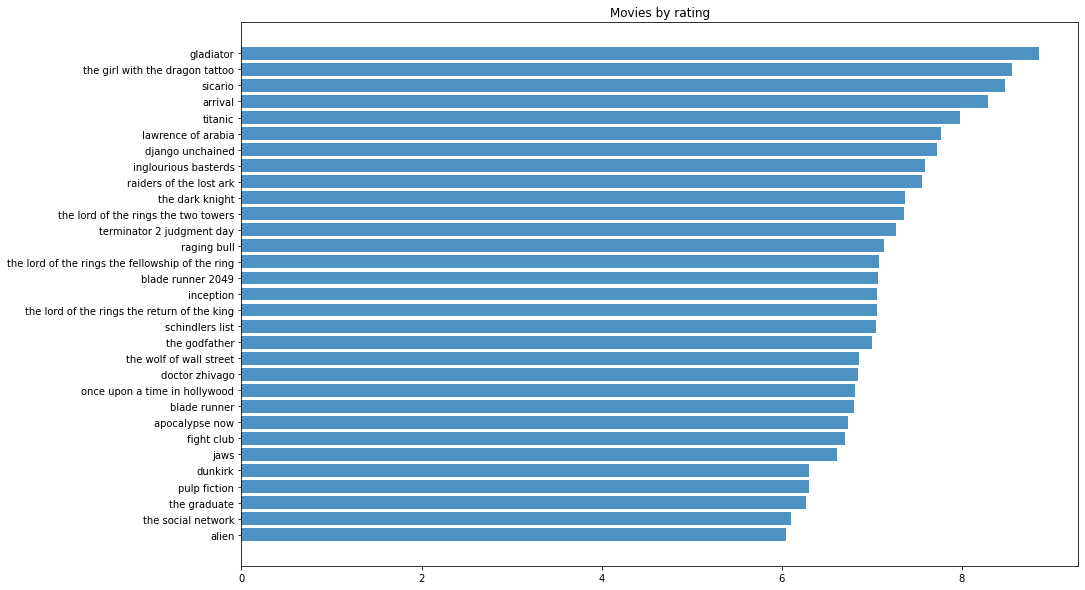

In [417]:
plt.figure(figsize = (15,10))
plt.barh(temporal_df.movie,temporal_df.rating, alpha = 0.8);
plt.title('Movies by rating');

#### rating by genre
- now we observe whith genres accumulated the highest ratings

In [224]:
conn = sqlite3.connect('movie_database.db')
c = conn.cursor()

genre_ratings = []

c.execute("SELECT m.genre, AVG(r.average_rating) \
          FROM movies m \
          INNER JOIN ratings r \
          ON m.movie_title = r.movie_title \
          GROUP BY m.genre")
          
list_of_results = c.fetchall()
for element in list_of_results:
    genre_ratings.append(element)

conn.commit()
conn.close()

In [230]:
temporal_df = pd.DataFrame(genre_ratings)
temporal_df.columns = ['genre', 'rating']
display(temporal_df.head(6))

,genre,rating
0,action,7.640255
1,adventure,7.168221
2,drama,7.137742
3,horror,6.330842
4,sci fi,7.388187
5,war,6.302632


<BarContainer object of 6 artists>

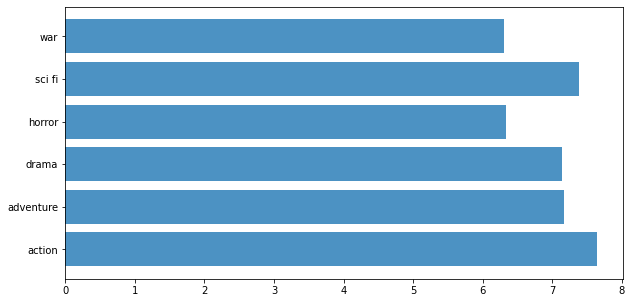

In [232]:
plt.figure(figsize = (10,5))
plt.barh(temporal_df.genre, temporal_df.rating, alpha = 0.8)
plt.title('Genre by rating');

#### revenue by director
- we can also find out which director brings most money. Of course this database does not include all movies made, but by all means if we included all movies of each director, and adjusted for inflation based on the year, we could find out which director is the most financially fruitful.

In [278]:
conn = sqlite3.connect('movie_database.db')
c = conn.cursor()

directors_revenue = []

c.execute("SELECT d.director, SUM(b.box_office), SUM(b.budget)   \
          FROM directors d \
          INNER JOIN box_office b \
          ON d.movie_title = b.movie_title \
          GROUP BY d.director")
          
list_of_results = c.fetchall()
for element in list_of_results:
    directors_revenue.append(element)

conn.commit()
conn.close()

In [320]:
temporal_df = pd.DataFrame(directors_revenue)
temporal_df.columns = ['director', 'box_office', 'budget']
temporal_df['ratio'] = temporal_df.box_office / temporal_df.budget
display(temporal_df.head())

,director,box_office,budget,ratio
0,Christopher Nolan,2247649450,445000000,5.050898
1,David Fincher,565117052,193000000,2.928068
2,David Lean,182035435,26000000,7.001363
3,Denis Villeneuve,546733991,227000000,2.408520
4,Francis Ford Coppola,354415469,37500000,9.451079


Text(0.5, 1.0, 'directors by box_offcce to budget ratio')

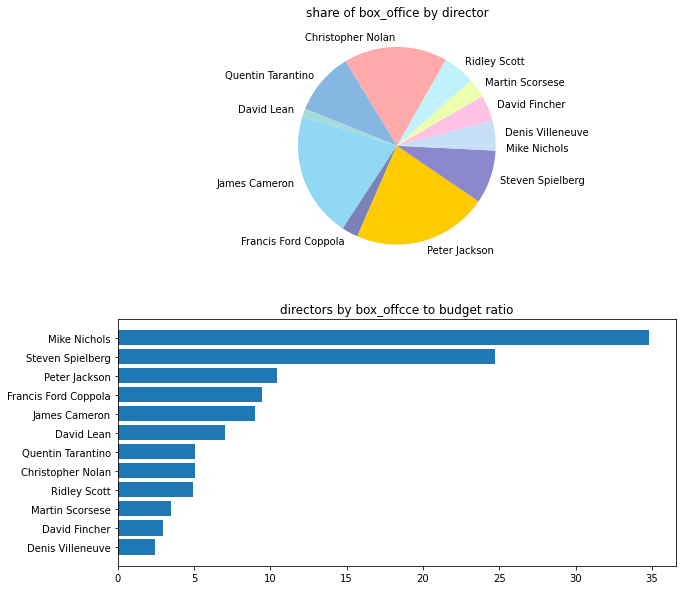

In [410]:
fig, ax = plt.subplots(2,1, figsize = (10,10))
colors = ['#c4dff6', '#ffc2e5','#ebffac','#c1f1fc','#ffaaaa','#85b7e2',
         '#a4dbdb','#91d8f4','#7c81b8','#fecb00','#8c88cd','#c4dff6']
ax[0].pie(temporal_df.box_office, labels = temporal_df.director,
         labeldistance = 1.1, colors = colors);
ax[0].set_title('share of box_office by director')
temporal_df.sort_values(by = 'ratio', inplace = True)
ax[1].barh(temporal_df.director, temporal_df.ratio)
ax[1].set_title('directors by box_offcce to budget ratio')

#### Biggest box_office hit and biggest box_office bomb
- we compare budgets and revenues to see which movies did well in relation to their budgets. Interesting results, Jaws with a budget of 7 million dollars was a star smashing hit with 476 million revenue. We can observe what a genius marketer James Cameron is with 2.76 billion revenue from a film about a sinking ship and two floating on a wardrobe. The graduate, a 1967 movie barely any adolescents know today made around 100 million on a 3 million budget. That's an equivalent of 800 million today, not bad for a film whose topicality would not stand a chance today to achieve that number. Then we see the sad cases, the fight club, sicario, apocalypse now, raging bull, all movies that did not exceed their budget by too much. We can also notice that movies titled blade runner are doomed for poor box office performance.

In [424]:
conn = sqlite3.connect('movie_database.db')
c = conn.cursor()

financial_info = []

c.execute("SELECT d.director, b.box_office, b.budget, m.movie_title, r.average_rating  \
          FROM directors d \
          INNER JOIN box_office b \
          ON d.movie_title = b.movie_title \
          INNER JOIN movies m \
          ON m.movie_title=b.movie_title \
          INNER JOIN ratings r \
          ON b.movie_title=r.movie_title")
          
list_of_results = c.fetchall()
for element in list_of_results:
    financial_info.append(element)

conn.commit()
conn.close()

In [430]:
temporal_df = pd.DataFrame(financial_info)
temporal_df.columns = ['director', 'box_office', 'budget', 'movie_title', 'rating']
temporal_df['ratio'] = temporal_df.box_office / temporal_df.budget
temporal_df.sort_values(by = 'ratio', inplace = True)
display(temporal_df.head())

,director,box_office,budget,movie_title,rating,ratio
25,Martin Scorsese,23380513,18000000,raging bull,7.140000,1.298917
8,Ridley Scott,39534078,28000000,blade runner,6.802817,1.411931
21,David Fincher,100820947,63000000,fight club,6.706897,1.600332
17,Denis Villeneuve,259212348,150000000,blade runner 2049,7.074074,1.728082
22,David Fincher,239373970,90000000,the girl with the dragon tattoo,8.555556,2.659711


<ipython-input-503-0bc1030a2777>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(temporal_df.movie_title)


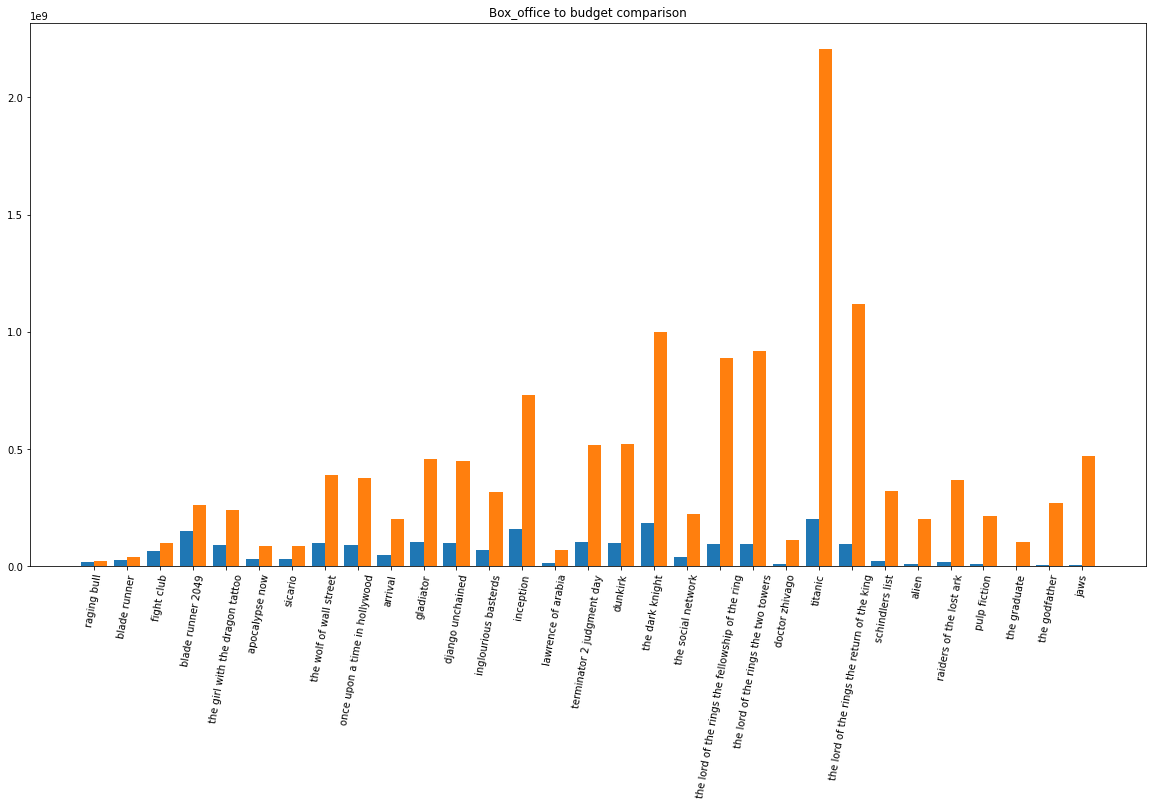

In [503]:
fig, ax = plt.subplots(figsize = (20,10))
width = 0.4
x = np.arange(len(temporal_df.movie_title))

ax.bar(x, temporal_df.budget, width = width)
ax.bar(x + width, temporal_df.box_office, width = width)

ax.set_xticklabels(temporal_df.movie_title)
ax.set_xticks(x + width/2)
ax.xaxis.set_tick_params(rotation=80)

ax.set_title('Box_office to budget comparison');

#### budget and rating
- finally we analyze the relation between budget and rating. 

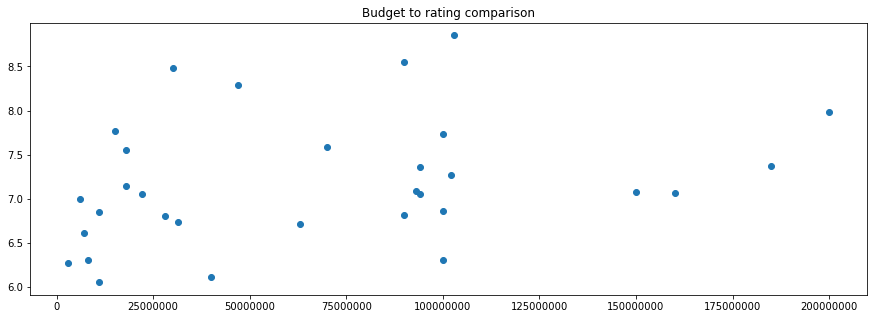

In [502]:
fig, ax = plt.subplots(figsize = (15,5))
ax.scatter(temporal_df.budget, temporal_df.rating)
ax.ticklabel_format(useOffset=False, style = 'plain')
plt.title('Budget to rating comparison');

#### Thank you